# Air Temperature Prediction using Random Forest Regressor
* ## Hourly Weather Surface – Brazil (Southeast region)

The main object is to create a model capable of predicting the air temperature using the Random Forest algorithm. For that, I used the [Hourly Weather Surface – Brazil (Southeast region) dataset](https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region). The main reason for choosing this dataset was for practicing data wrangling and feature engeenering, which are a very time consuming as well as an important part of a data scientist' work.

The dataset covers hourly weather data from 122 weathers stations of southeast region (Brazil). The southeast include the states of Rio de Janeiro, São Paulo, Minas Gerais e Espirito Santo. Dataset Source: INMET (National Meteorological Institute – Brazil).

![](https://assets.thehansindia.com/h-upload/2019/12/01/241086-weather-forecast-andhra-pra.jpg)


### Setup

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Because the dataset includes over 9 million observations, I faced computacional limitations which made me select only the first million rows.

In [117]:
sudeste = pd.read_csv('sudeste.csv',nrows=1000000) # Select only 1 million observations
columns = {'wsid':'weather_station_id', 'wsnm':'name_station','elvt':'elevation','lat':'latitude','lon':'longitude',
          'inme':'INMET_number','prov':'state','mdct':'observation_datetime','yr':'year','mo':'month',
          'da':'day','hr':'hour','prcp':'precipitation_milimetres','stp':'air_pressure','smax':'max_air_pressure',
          'smin':'min_air_pressure','gbrd':'solar_radiation','temp':'air_temperature','dewp':'dew_point_temperature',
           'tmax':'maximum_temperature','dmax':'maximum_dew_point_temperature','tmin':'minimum_temperature','dmin':'minimum_dew_point_temperature',
          'hmdy':'reletive_humid','hmax':'maximum_relative_humid_temp', 'hmin':'minimum_relative_humid_temp',
          'wdsp':'wind_speed','wdct':'wind_directio', 'gust':'wind_gust'}
# Rename the features
sudeste.rename(columns=columns, inplace=True)
# Setting the seed
random.seed(42)

### Feature description 
* wsid - Weather station id
* wsnm - Name station
* elvt - Elevation
* lat - Latitude
* lon - Longitude
* inme - Station number (INMET number) for the location
* city - City
* prov - State (Province)
* mdct - Observation Datetime (complete date: date + time)
* date - Date of observation
* yr - The year (2000-2016)
* mo - The month (0-12)
* da - The day (0-31)
* hr - The hour (0-23)
* prcp - Amount of precipitation in millimetres (last hour)
* stp - Air pressure for the hour in hPa to tenths (instant)
* smax - Maximum air pressure for the last hour in hPa to tenths
* smin - Minimum air pressure for the last hour in hPa to tenths
* gbrd - Solar radiation KJ/m2
* temp - Air temperature (instant) in celsius degrees
* dewp - Dew point temperature (instant) in celsius degrees
* tmax - Maximum temperature for the last hour in celsius degrees
* dmax - Maximum dew point temperature for the last hour in celsius degrees
* tmin - Minimum temperature for the last hour in celsius degrees
* dmin - Minimum dew point temperature for the last hour in celsius degrees
* hmdy - Relative humid in % (instant)
* hmax - Maximum relative humid temperature for the last hour in %
* hmin - Minimum relative humid temperature for the last hour in %
* wdsp - Wind speed in metres per second
* wdct - Wind direction in radius degrees (0-360)
* gust - Wind gust in metres per second

### Overview

In [118]:
sudeste.head()

,weather_station_id,name_station,elevation,latitude,longitude,INMET_number,city,state,observation_datetime,date,year,month,day,hour,precipitation_milimetres,air_pressure,max_air_pressure,min_air_pressure,solar_radiation,air_temperature,dew_point_temperature,maximum_temperature,maximum_dew_point_temperature,minimum_temperature,minimum_dew_point_temperature,reletive_humid,maximum_relative_humid_temp,minimum_relative_humid_temp,wind_speed,wind_directio,wind_gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,2007,11,6,0,NaN,982.5,982.5,981.3,NaN,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,2007,11,6,1,NaN,983.2,983.2,982.5,NaN,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,2007,11,6,2,NaN,983.5,983.5,983.2,NaN,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,2007,11,6,3,NaN,983.7,983.7,983.4,NaN,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,2007,11,6,4,NaN,983.7,983.8,983.6,NaN,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [119]:
# Number of observations and features, respectively.
sudeste.shape

(1000000, 31)

In [120]:
# All features
sudeste.columns

Index(['weather_station_id', 'name_station', 'elevation', 'latitude',
       'longitude', 'INMET_number', 'city', 'state', 'observation_datetime',
       'date', 'year', 'month', 'day', 'hour', 'precipitation_milimetres',
       'air_pressure', 'max_air_pressure', 'min_air_pressure',
       'solar_radiation', 'air_temperature', 'dew_point_temperature',
       'maximum_temperature', 'maximum_dew_point_temperature',
       'minimum_temperature', 'minimum_dew_point_temperature',
       'reletive_humid', 'maximum_relative_humid_temp',
       'minimum_relative_humid_temp', 'wind_speed', 'wind_directio',
       'wind_gust'],
      dtype='object')

In [121]:
# Null Values
sudeste.isna().sum().sort_values(ascending=False)

precipitation_milimetres         867299
solar_radiation                  423331
wind_speed                        21767
wind_gust                          4806
minimum_dew_point_temperature        25
dew_point_temperature                13
maximum_dew_point_temperature         4
city                                  0
date                                  0
observation_datetime                  0
state                                 0
INMET_number                          0
month                                 0
longitude                             0
latitude                              0
elevation                             0
name_station                          0
year                                  0
air_pressure                          0
day                                   0
hour                                  0
wind_directio                         0
max_air_pressure                      0
min_air_pressure                      0
air_temperature                       0


In [122]:
sudeste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   weather_station_id             1000000 non-null  int64  
 1   name_station                   1000000 non-null  object 
 2   elevation                      1000000 non-null  float64
 3   latitude                       1000000 non-null  float64
 4   longitude                      1000000 non-null  float64
 5   INMET_number                   1000000 non-null  object 
 6   city                           1000000 non-null  object 
 7   state                          1000000 non-null  object 
 8   observation_datetime           1000000 non-null  object 
 9   date                           1000000 non-null  object 
 10  year                           1000000 non-null  int64  
 11  month                          1000000 non-null  int64  
 12  day            

In [123]:
# Descriptive statistics
sudeste.describe()

,weather_station_id,elevation,latitude,longitude,year,month,day,hour,precipitation_milimetres,air_pressure,max_air_pressure,min_air_pressure,solar_radiation,air_temperature,dew_point_temperature,maximum_temperature,maximum_dew_point_temperature,minimum_temperature,minimum_dew_point_temperature,reletive_humid,maximum_relative_humid_temp,minimum_relative_humid_temp,wind_speed,wind_directio,wind_gust
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,132701.000000,1000000.000000,1000000.000000,1000000.000000,576669.000000,1000000.000000,999987.000000,1000000.000000,999996.000000,1000000.000000,999975.000000,1000000.000000,1000000.000000,1000000.000000,978233.000000,1000000.000000,995194.000000
mean,297.892288,394.163992,-19.045355,-41.407966,2011.028808,6.509904,15.749056,11.499936,1.102290,923.542423,923.351782,922.805438,1190.617195,21.667751,16.633922,22.250722,17.098418,21.103181,16.168882,71.263957,73.791652,68.550058,2.166330,149.786228,4.881029
std,35.023232,453.756411,3.647361,2.243426,3.224740,3.438836,8.802272,6.922178,3.051955,217.710360,218.686644,218.589647,1133.171456,6.766497,5.267017,6.993508,5.345899,6.574414,5.229528,23.979135,23.723096,24.229691,1.555289,109.273584,2.825134
min,178.000000,9.000000,-21.228373,-46.949617,2002.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.100000,0.000000,-5.100000,0.000000,-8.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,305.000000,29.000000,-20.750412,-41.488852,2009.000000,4.000000,8.000000,5.000000,0.000000,904.700000,905.000000,904.400000,74.661000,18.900000,14.900000,19.400000,15.400000,18.500000,14.400000,59.000000,64.000000,55.000000,1.000000,60.000000,2.700000
50%,307.000000,129.000000,-19.988388,-40.741818,2011.000000,7.000000,16.000000,11.000000,0.200000,998.000000,998.200000,997.700000,907.053000,22.400000,17.700000,23.000000,18.200000,21.900000,17.300000,77.000000,81.000000,74.000000,1.900000,122.000000,4.700000
75%,311.000000,976.000000,-19.356923,-40.068680,2014.000000,9.000000,23.000000,17.000000,0.800000,1010.500000,1010.800000,1010.300000,2094.086000,25.600000,20.200000,26.400000,20.600000,24.900000,19.700000,90.000000,91.000000,88.000000,3.000000,235.000000,6.700000
max,313.000000,1169.000000,-6.835777,-38.311583,2016.000000,12.000000,31.000000,23.000000,96.800000,1030.300000,1030.400000,1030.200000,7218.496000,43.500000,35.000000,45.000000,35.700000,42.300000,33.600000,100.000000,100.000000,100.000000,19.100000,360.000000,25.000000


## Data Wranglig and Feature Engeneering

### Null Values' Treatment

In [124]:
sudeste.isna().sum()[sudeste.isna().sum()>0]

precipitation_milimetres         867299
solar_radiation                  423331
dew_point_temperature                13
maximum_dew_point_temperature         4
minimum_dew_point_temperature        25
wind_speed                        21767
wind_gust                          4806
dtype: int64

In [125]:
# Percentage of null values
sudeste.isna().sum()[sudeste.isna().sum()>0]/sudeste.shape[0]

precipitation_milimetres         0.867299
solar_radiation                  0.423331
dew_point_temperature            0.000013
maximum_dew_point_temperature    0.000004
minimum_dew_point_temperature    0.000025
wind_speed                       0.021767
wind_gust                        0.004806
dtype: float64

Because the``precipitation_milimetres`` feature has close to 90% percent of null values, I decided to remove as it would have an impact in the model's result even if I tried to impute the values.  

In [126]:
sudeste.drop('precipitation_milimetres', axis=1, inplace=True)

### Imputation of numeric variables with scikitlearn's `IterativeImputer`

There are several ways of leading with missing values in data science, like filling with mean, median or mode, using k-NN (feature similarity). In this case, I chose the imputation through regression.
* Choosen estimator: DecisionTreeRegressor (non-linear regression) as we assume that the features do not have linear relationships

In [127]:
# Selecting the features with NAs
numeric_null = sudeste.isna().sum()[sudeste.isna().sum()>0].index.to_list()

In [128]:
# Creating the imputer
imputer = IterativeImputer(estimator=DecisionTreeRegressor())
numeric_imputed = tqdm(imputer.fit_transform(sudeste[numeric_null]))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
  0%|                                                                                      | 0/1000000 [00:00<?, ?it/s]

In [129]:
# Assigning the imputed features back to the dataframe
sudeste[numeric_null]=pd.DataFrame(data=numeric_imputed, columns=numeric_null)

100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 500694.10it/s]


Then, the correlation matrix can help us to analyse which feature are relevant and which as obsolete. Features that have a high correlation and express very similar phenomenons can be removed. 

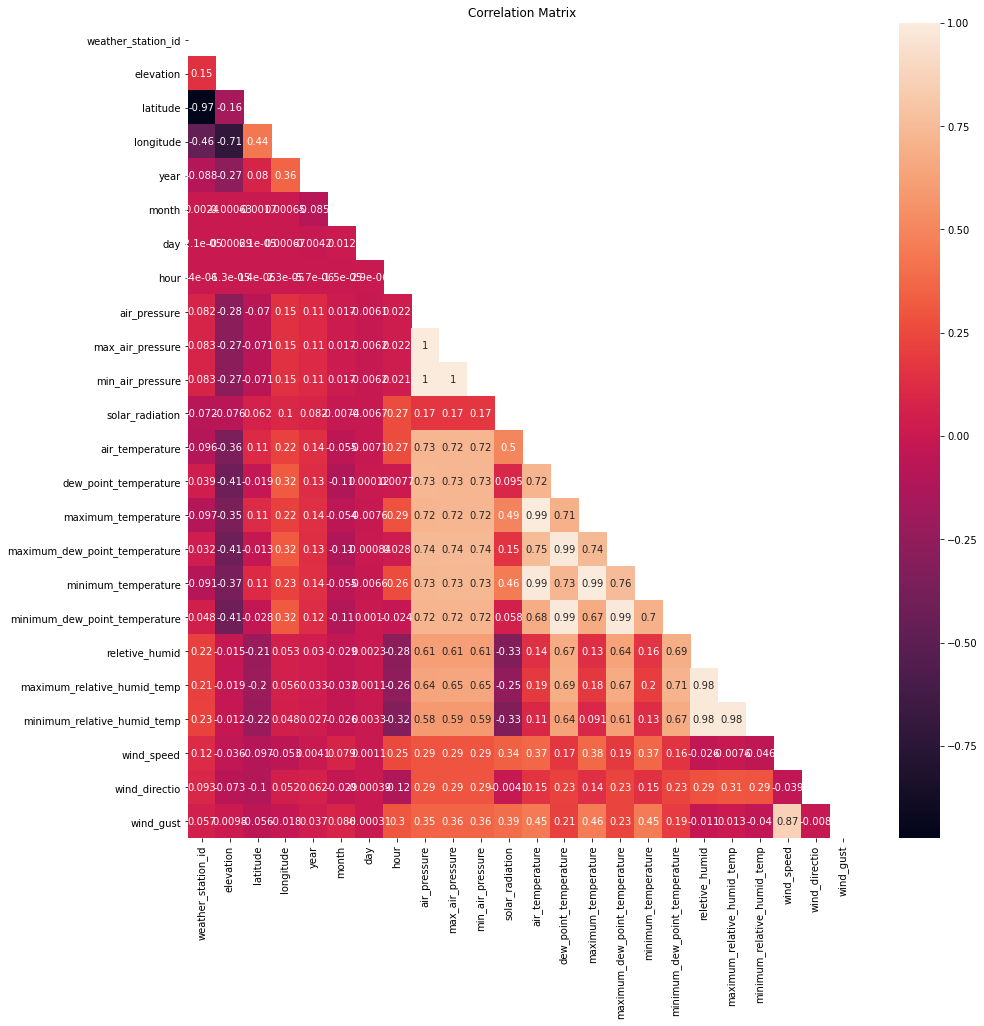

In [130]:
mask = np.triu(sudeste.corr())
plt.figure(figsize=(15,15))
sns.heatmap(sudeste.corr(), annot=True, mask=mask, );
plt.title('Correlation Matrix');

It's possible to obtain some conclusion from the observation of the correlation matrix. For example, it's not necessary to use `air_pressure`, `max_air_pressure` and `min_air_pressure` as their correlation as igual to 1, therefore we'll use only the `air_pressure`. The same process can be applied to `air_temperature`, `maximum_temperature`, `minimum_temperature`; to`dew_point_temperature`, `maximum_dew_point_temperature`, `minimum_dew_point_temperature`; and `relative_humid`, `maximum_relative_humid_temp`, `minimum_relative_humid_temp`. We'll also select `wind_speed` at the expense of `wind_gust` because of their high correlation and their equal unit of measurement.

Moreover, I decided to remove the `observation_datetime` and `date` because there are already features (`year`, `month`, etc.) that describe these informations more precisely.

In [131]:
removed_features = ['max_air_pressure', 'min_air_pressure','maximum_temperature', 'minimum_temperature', 'maximum_dew_point_temperature',
         'minimum_dew_point_temperature', 'maximum_relative_humid_temp','minimum_relative_humid_temp',
         'wind_gust','observation_datetime','date']
sudeste.drop(removed_features, axis=1, inplace=True)


### Exploratory Data Analysis

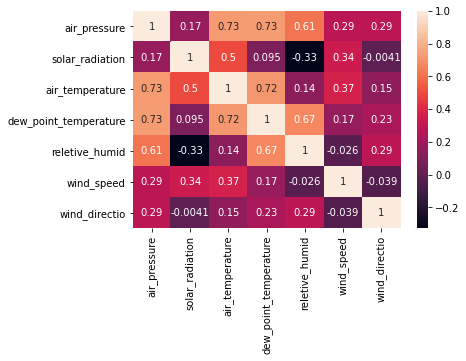

In [132]:
# Taking a closer look at the numeric features
sns.heatmap(sudeste[['air_pressure','solar_radiation','air_temperature', 'dew_point_temperature','reletive_humid','wind_speed','wind_directio']].corr(), annot=True);

In [133]:
# Air temperature mean by year
sudeste.groupby('year')['air_temperature'].mean()

year
2002     7.246771
2003    14.841484
2004    16.841974
2005    19.024561
2006    20.179297
2007    22.182614
2008    21.180091
2009    21.475274
2010    22.356584
2011    21.011256
2012    22.596296
2013    21.917798
2014    22.153248
2015    22.599664
2016    22.601787
Name: air_temperature, dtype: float64

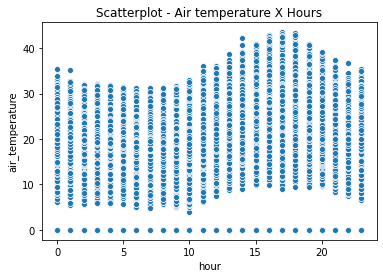

In [134]:
sns.scatterplot(x=sudeste.hour, y=sudeste.air_temperature);
plt.title('Scatterplot - Air temperature X Hours');

The scatterplot above shows that the regions analysed presented a high variance of temperature in all hours throughtout the day as shown by the high margin of temperature that each hour had. The tendency was to ocurr a peak of temperature  around 12h to 18h as the coldest hours happened during dawn and early morning (2h to 8h).

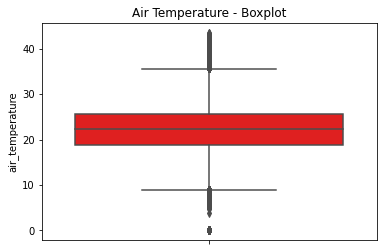

In [135]:
sns.boxplot(x=sudeste.air_temperature,orient='vertical',color='red');
plt.title('Air Temperature - Boxplot');

In [136]:
# Observing the outliers
iqr = sudeste.air_temperature.quantile(0.75)-sudeste.air_temperature.quantile(0.25)
sup_whisker = sudeste.air_temperature.quantile(0.75)+(1.5*iqr).round(2)
inf_whisker = sudeste.air_temperature.quantile(0.25)-(1.5*iqr).round(2)
print('Number of superior outliers: ', sudeste.air_temperature[sudeste.air_temperature>sup_whisker].count())
print('Number of inferior outliers: ', sudeste.air_temperature[sudeste.air_temperature<inf_whisker].count())
print('Total number of outliers: ',sudeste.air_temperature[sudeste.air_temperature>sup_whisker].count() + sudeste.air_temperature[sudeste.air_temperature<inf_whisker].count()) 

Number of superior outliers:  2651
Number of inferior outliers:  49971
Total number of outliers:  52622


In [137]:
print('Maximum reached temperature: ', sudeste.air_temperature.max())
print('Minimum reached temperature: ', sudeste.air_temperature.min())

Maximum reached temperature:  43.5
Minimum reached temperature:  0.0


It's important to notice that problems in the data collection may happen and can influence the analysis. For example, the year 2002's air temperature mean (7.25) might had been influenced by many zero occurances, that may be a result of a measurament failure. This can also be seen in the boxplot and in the high number of inferior ouliers.

### Categorical features manipulation

In [138]:
categorial_removed = ['weather_station_id','name_station', 'city', 'state','INMET_number']
sudeste.drop(categorial_removed, axis=1, inplace=True)

I decided to remove the above features because they did not represent any relevance to the calculation of the air temperature, our target variable. Their underlying information which is the location of the weather measuremment is already satisfied by the variables `latitude` and `longitude`

### Model's preparation

In [139]:
x = sudeste.drop('air_temperature', axis=1) # Independent features
y = sudeste.air_temperature # Target feature 

### Dataset's division between train and test

As we do not have new data to input into out model, we need to separate our dataset into a set of train and a set of test. For this purpose, scikit-learn have the method `train_test_split` where we input the independent features, the target feature and the proportion between train and test sets.

In [140]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)
print('x_train: ', x_train.shape)
print('x_test: ',x_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

x_train:  (700000, 13)
x_test:  (300000, 13)
y_train:  (700000,)
y_test:  (300000,)


### Random Forest 

Random Forest is one of the most accurate learning algorithms available, being a supervised learning algorithm which uses ensemble learning method for classification and regression.

It works by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

[ref](https://towardsdatascience.com/random-forest-and-its-implementation-71824ced454f)

In [141]:
random_forest = RandomForestRegressor(random_state=42)

In [142]:
random_forest.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [143]:
y_pred = random_forest.predict(x_test)

### Regression Validation

We can use different validation metrics to evaluate our model's perfomance. Here, I chose two different metrics for the sake of comparasion. First, the mean squared error that measures the average of the squares of the errors, in other words, the average squared difference between the estimated values and the actual value. Second, median absolute error that is measures the median of the absolute deviations between the estimated values and the actual value, being robust to the presence of outlier because it focus in the results' quantiles, not its mean.

For both, the lower the result, the better the model's perfomance.

In [144]:
mean_squared_error(y_test, y_pred)

0.015758860886666663

In [145]:
median_absolute_error(y_test, y_pred)

0.056999999999995055

With the results in hand, we can see that the model has a very solid perfomance. The data wrangling and feature engeneering part were fundamental to the outcome reached. Other imporant aspect of the process of building this random forest regression model is the elevated size of the dataset: with a high number of observation, the model can be better trained thus gaining better outputs.

João Pedro Vazquez 2020.

[Github](https://github.com/jpvazquezz)
[LinkedIn](https://www.linkedin.com/in/jo%C3%A3o-pedro-vazquez/)